<a href="https://colab.research.google.com/github/heidiray/stats_comps/blob/main/statscomp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

import math # used for autograding and other utilities

# These lines do some fancy plotting magic
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
from matplotlib import patches
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [ ]:
#function statistic to take in an expected proportion and an actual or observed proportion, and return the relevant statistic
def statistic(expected_prop, actual_prop):
    return actual_prop - expected_prop
observed_statistic = statistic(0.5, 0.7)
observed_statistic

0.19999999999999996

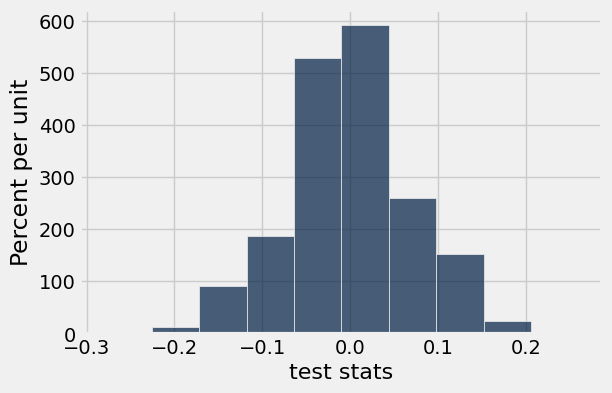

In [ ]:
def simulation_and_statistic(model_proportions, exp_prop):
    '''Simulates 50 key choices under John’s skeptical model.
    Returns one statistic from the simulation.'''
    model_proportions = make_array(0.5, 0.5)
    exp_prop = sample_proportions(50, model_proportions)
    return statistic(exp_prop.item(1), model_proportions.item(1))
num_repetitions = 5000
simulated_statistics = make_array()
for i in np.arange(5000):
    test_sim = simulation_and_statistic(make_array(0.5, 0.5), 0.5)
    simulated_statistics = np.append(simulated_statistics, test_sim)

simulated_statistics
Table().with_column('test stats', simulated_statistics).hist()

time,like,where,freq,busy,educ,sex,age,home,math,work,own,cdrom,email,grade
2,3,3,2,0,1,0,19,1,0,10,1,0,1,4
0,3,3,3,0,0,0,18,1,1,0,1,1,1,2
0,3,1,3,0,0,1,19,1,0,0,1,0,1,3
0.5,3,3,3,0,1,0,19,1,0,0,1,0,1,3
0,3,3,4,0,1,0,19,1,1,0,0,0,1,3
0,3,2,4,0,0,1,19,0,0,12,0,0,0,3
0,4,3,4,0,0,1,20,1,1,10,1,0,1,3
0,3,3,4,0,0,0,19,1,0,13,0,0,1,3
2,3,2,1,1,1,1,19,0,0,0,0,0,0,4
0,3,3,4,0,1,1,19,1,1,0,1,0,1,4


0.5959

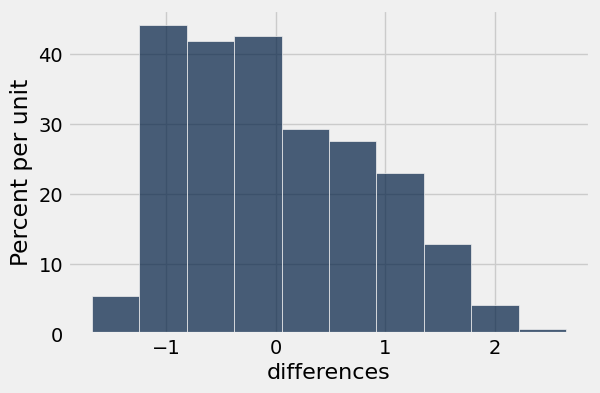

In [ ]:
#compare 2 samples
# load this survey data with video game usage
url='https://drive.google.com/file/d/1uwfdox0VG7ZUsvXkwAsUFW-kBUnw2_9Z/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
videogames = Table.read_table(dwn_url,sep = ",")

#videogames = Table.read_table('videos.csv')
videogames.show(10)

#create a table
time_and_math = Table().with_columns('math class', videogames.column('math'), 'time', videogames.column('time'))
rate_means = (time_and_math.group('math class', np.average)).where('math class', are.not_above(1))
rate_means

#calc test stat
means = rate_means.column(1)
observed_difference = means.item(0) - means.item(1)
observed_difference

#calc mean distance between groups
def find_test_stat(table, labels_col, values_col):
  return np.average(table.column(values_col))

find_test_stat(videogames, "math", "time")

#random permutations
def simulate_and_test_statistic(table, labels_col, values_col):
    shuffled_labels = table.sample(with_replacement=False).column(labels_col)
    original_and_shuffled = table.select(values_col).with_column(
        'Shuffled Label', shuffled_labels)
    shuffle_means = original_and_shuffled.group('Shuffled Label', np.average)
    means = shuffle_means.column(1)
    return means.item(1) - means.item(0)
simulate_and_test_statistic(videogames, "math", "time")

#simulate 10000 trials
differences = make_array()
repetitions = 10000
for i in np.arange(repetitions):
  trials = simulate_and_test_statistic(videogames, 'math', 'time')
  differences = np.append(differences, trials)


differences


#plot differences distr
Table().with_column('differences', differences).hist()

#calculate p value
empirical_P = np.count_nonzero(differences <= observed_difference) / repetitions
empirical_P

year,growth,vote,inc_party_candidate,other_candidate
1952,2.4,44.6,Stevenson,Eisenhower
1956,2.89,57.76,Eisenhower,Stevenson
1960,0.85,49.91,Nixon,Kennedy
1964,4.21,61.34,Johnson,Goldwater
1968,3.02,49.6,Humphrey,Nixon
1972,3.62,61.79,Nixon,McGovern
1976,1.08,48.95,Ford,Carter
1980,-0.39,44.7,Carter,Reagan
1984,3.86,59.17,Reagan,Mondale
1988,2.27,53.94,Bush_Sr,Dukakis


growth SU,vote SU
0.371885,-1.37271
0.734519,1.05048
-0.775223,-0.394966
1.71141,1.70968
0.830728,-0.452048


99% CI: [0.6355373450564398, 4.169422374395817] , Reject the null: True
95% CI: [47.98822382575652, 51.14790513427307]


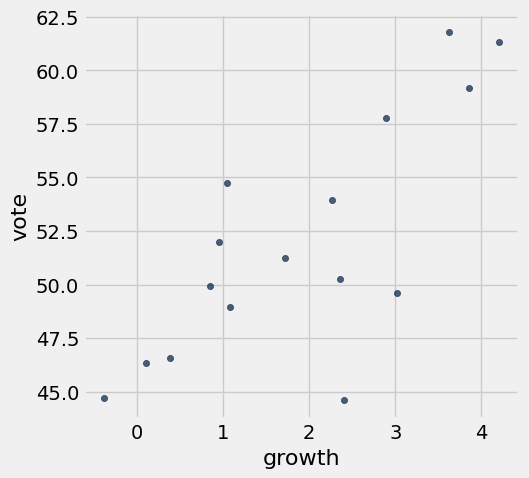

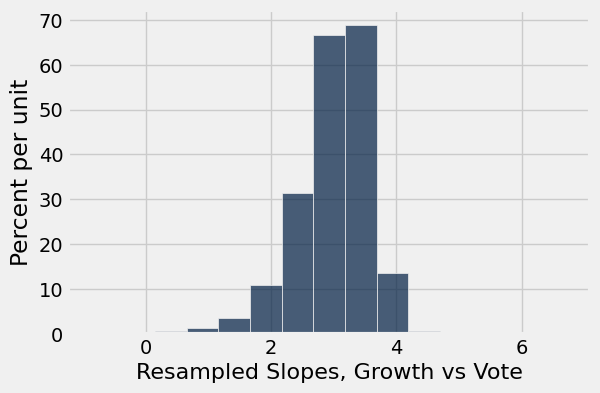

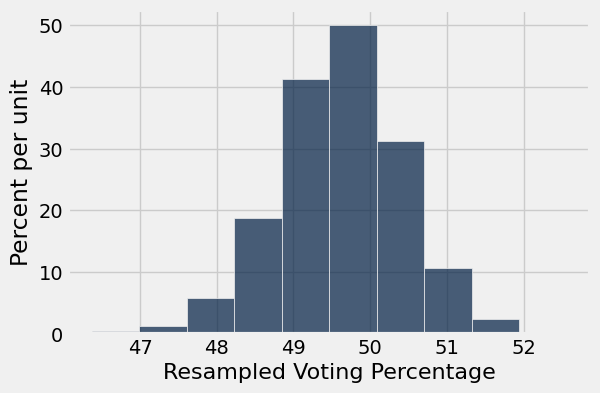

In [ ]:
#predictions
url='https://drive.google.com/file/d/1vGru83BtSDkVj-i-t3cVRdoUr42Tt3oz/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id
hibbs = Table.read_table(dwn_url,sep = ",")

#hibbs = Table.read_table('hibbs.csv')
hibbs.show(10)

#Plot the relationship between tthe average income growth (growth) and the share of the vote (vote).
hibbs.scatter('growth', 'vote')

#calculate the correlation between economic growth and share of the votes
def standard_units(arr):
    return (arr - np.mean(arr))/np.std(arr)

hibbs_su = Table().with_columns(
    "growth SU", standard_units(hibbs.column("growth")),
    "vote SU", standard_units(hibbs.column("vote"))
)
hibbs_su.show(5)

def correlation(tbl, col1, col2):
    return np.mean(standard_units(tbl.column(col1))*standard_units(tbl.column(col2)))

growth_vote_corr = correlation(hibbs, 'growth', 'vote')
growth_vote_corr

#Define a function that returns the parameters of the regression line
def correlation(tbl, lbl_x, lbl_y):
        return np.mean(standard_units(tbl.column(lbl_x))*standard_units(tbl.column(lbl_y)))

def slope(tbl, lbl_x, lbl_y):
       r = correlation(tbl, lbl_x, lbl_y)
       return r*np.std(tbl.column(lbl_y))/np.std(tbl.column(lbl_x))

def intercept(tbl, lbl_x, lbl_y):
      return np.mean(tbl.column(lbl_y)) - slope(tbl, lbl_x, lbl_y)*np.mean(tbl.column(lbl_x))

def regression_parameters(tbl, lbl_x, lbl_y):
    intercept1 = intercept(tbl, lbl_x, lbl_y)
    slope1 = slope(tbl, lbl_x, lbl_y)
    return make_array(slope1, intercept1)


parameters = regression_parameters(hibbs, "growth", "vote")
parameters

#test
#Null Hypothesis: There is no relationship between vote share for the independent party and economic growth.
#Alternative Hypothesis: There is a relationship between vote share for the independent party and economic growth

def one_resample_b(tbl, lbl_x, lbl_y):
    new_bootstrap = tbl.sample()
    return slope(new_bootstrap, lbl_x, lbl_y)
one_resample_slope = one_resample_b(hibbs, "growth", "vote")
one_resample_slope
resampled_slopes_pc = make_array()

for i in np.arange(5000):
    lots_o_slopes = one_resample_b(hibbs, 'growth', 'vote')
    resampled_slopes_pc = np.append(resampled_slopes_pc, lots_o_slopes)
#plot
Table().with_column("Resampled Slopes, Growth vs Vote", resampled_slopes_pc).hist(bins = 15)

#calculate a 99 percent confidence interval
lower_bound_slopes_pc = percentile(0.5, resampled_slopes_pc)
upper_bound_slopes_pc = percentile(99.5, resampled_slopes_pc)
reject = True
print(f"99% CI: [{lower_bound_slopes_pc}, {upper_bound_slopes_pc}] , Reject the null: {reject}")

#forecasted vote change
pred_vote = (3.06052805 * 3.4) + 46.24764802
pred_vote

#bootstrap sample of pred_vote
def one_resample_prediction(tbl, colx, coly, xvalue):
    parameters_tbl = regression_parameters(tbl.sample(), colx, coly)
    return parameters_tbl.item(0) * xvalue + parameters_tbl.item(1)

pred_vote_resample = one_resample_prediction(hibbs, "growth", "vote", 2)
pred_vote_resample

#see variability in predictions
resampled_predictions = make_array()
for i in np.arange(5000):
  one_one_predictions = one_resample_prediction(hibbs, 'growth', 'vote', 1.1)
  resampled_predictions = np.append(resampled_predictions, one_one_predictions)
# Don't change/delete the code below in this cell
Table().with_column("Resampled Voting Percentage", resampled_predictions).hist()

#95 percent confidence interval
lower_bound_4_12 = percentile(2.5, resampled_predictions)
upper_bound_4_12 = percentile(97.5, resampled_predictions)


print(f"95% CI: [{lower_bound_4_12}, {upper_bound_4_12}]")